# Machine Learning 1 - Regression project

In this project I am doing regression on weather data and making predictions on traffic. At the very beginning I do the data preparation. I clean them of outliers and prepare them for further prediction. To make predictions I use machine learning algorithms (Linear, Lasso, Ridge and Elastic Net Regression, Random Forrest, KNN regressor, SVM), compare their performance and make predictions on a test set.</br>
The main task of the project is to make a prediction with the lowest possible prediction error as measured by MAPE (Mean Absolute Percentage Error).

# Import libraries

Let's begin with importing all necessary libraries

In [594]:
import warnings
warnings.filterwarnings("ignore")
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

from sklearn import linear_model
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, roc_auc_score, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Data preparation

The dataset includes the following columns:
- `date_time` – date and time (1 hourly interval)
- `weather_general` – general short description of the current weather with the following levels: Clear, Clouds, Drizzle, Fog, Haze, Mist, Rain, Smoke, Snow, Squall, Thunderstorm
- `weather_detailed` – more detailed description of the current weather with the following levels: broken clouds, drizzle, few clouds, fog, freezing rain, haze, heavy intensity drizzle, heavy intensity rain, heavy snow, light intensity drizzle, light intensity shower rain, light rain, light rain and snow, light shower snow, light snow, mist, moderate rain, overcast clouds, proximity shower rain, proximity thunderstorm, proximity thunderstorm with drizzle, proximity thunderstorm with rain, scattered clouds, shower drizzle, shower snow, sky is clear, sleet, smoke, snow, squalls, thunderstorm, thunderstorm with drizzle, thunderstorm with heavy rain, thunderstorm with light drizzle, thunderstorm with light rain, thunderstorm with rain, very heavy rain
- `clouds_coverage` – percentage of sky covered by the clouds in the hourly interval
- `temperature` – average temperature in the hourly interval (in Celsius degrees)
- `rain_mm` – amount of rain that occurred in the hourly interval (in mm)
- `snow_mm` – amount of snow that occurred in the hourly interval (in mm)
- `traffic` – the amount of traffic in the hourly interval (outcome variable, only in the training sample)

Import training dataset csv file

In [595]:
traffic_train = pd.read_csv("data/traffic_train.csv")
traffic_train = traffic_train.dropna()

traffic_train = traffic_train[traffic_train.traffic != 0]
traffic_train.shape

(29685, 8)

At the very beginning I decide to delete observations that are equal to 0. I consider them to be wrong. The initial dataset has 29685 observations and 8 variables.

I also import a test dataset.

In [596]:
traffic_test = pd.read_csv("data/traffic_test.csv")
print(traffic_test["snow_mm"].describe())
print(traffic_test["rain_mm"].describe())
traffic_test.drop(columns=['snow_mm', 'rain_mm'], inplace = True)

count    10591.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: snow_mm, dtype: float64
count    10591.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: rain_mm, dtype: float64


I move on to analyse the variables and prepare the data. The distribution of the explanatory variable `traffic` which is the target seems to be correct.

<AxesSubplot:xlabel='traffic', ylabel='Count'>

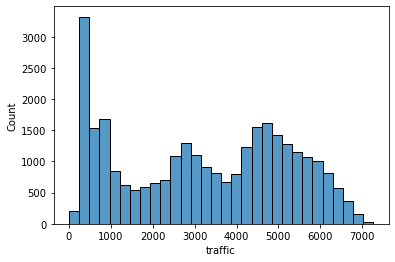

In [597]:
sns.histplot(data=traffic_train, x="traffic")

For `clouds_coverage_pct` I observe that values every 20 have the majority of observations. In later steps I combine the values between to rounded levels of every 20.

<AxesSubplot:xlabel='clouds_coverage_pct', ylabel='Count'>

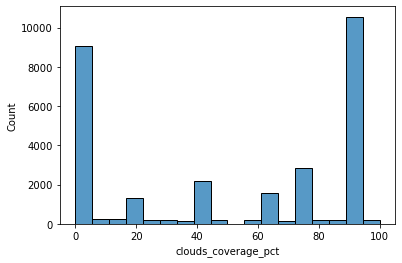

In [598]:
sns.histplot(data=traffic_train, x="clouds_coverage_pct")

For `temperature` I observe that there are outliers. I remove them in a later step.

<AxesSubplot:xlabel='temperature', ylabel='Count'>

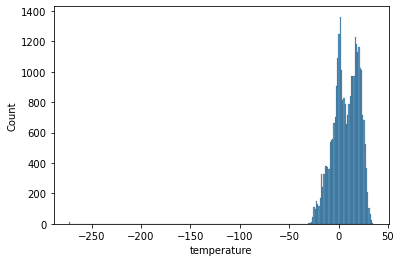

In [599]:
sns.histplot(data=traffic_train, x="temperature")

I draw a `target` chart for the first 168 observations (equivalent to one week). I see very strong daily seasonality. Two days seem to be smaller than the others, they are weekends. A correct transformation of the `date_time` variable will be crucial for the accuracy of the subsequent prediction.

<Figure size 432x288 with 0 Axes>

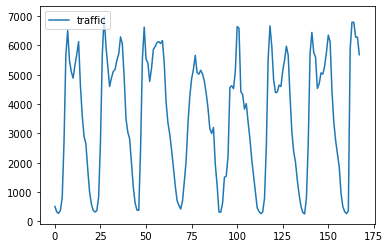

In [600]:
plt.figure()
traffic_train[["date_time", "traffic"]].head(168).plot()
plt.show()

Based on the observations made, I am removing all observations of temperatures below -50 degrees. I note that the columns `snow_mm`, `rain_mm` are redundant (in the test set all observations have a value of 0 for these variables). Further, as I said seasonality will be key with this data. Based on the `date_time` variable I create a numeric variable `month` (1-12), `hour` (0-23), `is_weekend` (dummy variable for weekend), `weekday` (1-7 for weekday).

In [601]:
traffic_train = traffic_train[traffic_train.temperature > -50]

traffic_train = traffic_train[traffic_train.snow_mm == 0]
traffic_train = traffic_train[traffic_train.rain_mm == 0]
traffic_train.drop(columns=['snow_mm', 'rain_mm'], inplace = True)

#traffic_train = traffic_train[traffic_train.rain_mm < 60]
#traffic_train['log_rain_mm'] = np.log(traffic_train.rain_mm+1)
#traffic_train = traffic_train[traffic_train.snow_mm < 120]
#traffic_train['log_snow_mm'] = np.log(traffic_train.snow_mm+1)

#traffic_train['year'] = pd.to_datetime(traffic_train['date_time']).dt.year
traffic_train['month'] = pd.to_datetime(traffic_train['date_time']).dt.month
traffic_train['hour'] = pd.to_datetime(traffic_train['date_time']).dt.hour
traffic_train["is_weekend"] = pd.to_datetime(traffic_train['date_time']).dt.dayofweek > 5
traffic_train['weekday'] = pd.to_datetime(traffic_train['date_time']).dt.dayofweek
#traffic_train = pd.get_dummies(traffic_train, columns=['weather_general', 'weather_detailed', 'year', 'month'])

In addition, I group the hours by time of day `Night`, `Morning`, `Noon`, `Evening`. I also combine the mentioned `clouds_coverage_pct` into levels every 20.

In [602]:
traffic_train['part_of_day'] = pd.cut(traffic_train['hour'], bins=[0,4,7,13,19,24], labels=['Night', 'Morning','Noon','Evening', 'Night'], include_lowest=True, ordered=False)
traffic_train['clouds_coverage_pct'] = pd.cut(x=traffic_train['clouds_coverage_pct'], bins=[-1,10,30,50,70,90,100], labels=[0, 20, 40, 60, 80, 100])

I create dummy variables.

In [603]:
traffic_train = pd.get_dummies(traffic_train, columns=['weather_general', 'weather_detailed', 'month', 'hour', 'is_weekend', 'weekday', 'part_of_day'])

I think the variables responsible for the weather details are too detailed. I arbitrarily combine them into larger, more generalised variables.

In [604]:
traffic_train["weather_general_Clouds"] = traffic_train["weather_general_Clouds"] + traffic_train["weather_general_Squall"]
traffic_train.drop(columns=["weather_general_Squall"], inplace=True)

traffic_train["weather_general_Clouds"] = traffic_train["weather_general_Clouds"] + traffic_train['weather_detailed_squalls']
traffic_train.drop(columns=['weather_detailed_squalls'], inplace=True)

traffic_train["weather_general_Fog"] = traffic_train["weather_general_Fog"] + traffic_train["weather_general_Smoke"]
traffic_train.drop(columns=["weather_general_Smoke"], inplace=True)


traffic_train["weather_detailed_drizzle"] = traffic_train["weather_detailed_drizzle"] + traffic_train["weather_detailed_heavy intensity drizzle"]
traffic_train.drop(columns=["weather_detailed_heavy intensity drizzle"], inplace=True)

traffic_train["weather_detailed_drizzle"] = traffic_train["weather_detailed_drizzle"] + traffic_train["weather_detailed_shower drizzle"]
traffic_train.drop(columns=["weather_detailed_shower drizzle"], inplace=True)

traffic_train["weather_detailed_drizzle"] = traffic_train["weather_detailed_drizzle"] + traffic_train['weather_detailed_light intensity drizzle']
traffic_train.drop(columns=['weather_detailed_light intensity drizzle'], inplace=True)

traffic_train["weather_detailed_light rain"] = traffic_train["weather_detailed_light rain"] + traffic_train["weather_detailed_light rain and snow"]
traffic_train.drop(columns=["weather_detailed_light rain and snow"], inplace=True)

traffic_train["weather_detailed_light rain"] = traffic_train["weather_detailed_light rain"] + traffic_train['weather_detailed_proximity shower rain']
traffic_train.drop(columns=['weather_detailed_proximity shower rain'], inplace=True)

traffic_train["weather_detailed_moderate rain"] = traffic_train["weather_detailed_moderate rain"] + traffic_train['weather_detailed_freezing rain']
traffic_train.drop(columns=['weather_detailed_freezing rain'], inplace=True)


traffic_train["weather_detailed_thunderstorm with rain"] = traffic_train["weather_detailed_thunderstorm with rain"] + traffic_train["weather_detailed_thunderstorm with light drizzle"]
traffic_train.drop(columns=["weather_detailed_thunderstorm with light drizzle"], inplace=True)


traffic_train["weather_detailed_light snow"] = traffic_train["weather_detailed_light snow"] + traffic_train["weather_detailed_light shower snow"]
traffic_train.drop(columns=["weather_detailed_light shower snow"], inplace=True)

traffic_train["weather_detailed_light snow"] = traffic_train["weather_detailed_light rain"] + traffic_train["weather_detailed_shower snow"]
traffic_train.drop(columns=["weather_detailed_shower snow"], inplace=True)

traffic_train["weather_detailed_snow"] = traffic_train["weather_detailed_snow"] + traffic_train["weather_detailed_sleet"]
traffic_train.drop(columns=["weather_detailed_sleet"], inplace=True)



traffic_train["weather_detailed_proximity thunderstorm"] = traffic_train["weather_detailed_proximity thunderstorm"] + traffic_train["weather_detailed_proximity thunderstorm with drizzle"]
traffic_train.drop(columns=["weather_detailed_proximity thunderstorm with drizzle"], inplace=True)

traffic_train["weather_detailed_proximity thunderstorm"] = traffic_train["weather_detailed_proximity thunderstorm"] + traffic_train["weather_detailed_proximity thunderstorm with rain"]
traffic_train.drop(columns=["weather_detailed_proximity thunderstorm with rain"], inplace=True)

traffic_train["weather_detailed_thunderstorm"] = traffic_train["weather_detailed_thunderstorm"] + traffic_train["weather_detailed_thunderstorm with heavy rain"] + traffic_train["weather_detailed_thunderstorm with light rain"] + traffic_train["weather_detailed_thunderstorm with rain"]
traffic_train.drop(columns=["weather_detailed_thunderstorm with heavy rain", "weather_detailed_thunderstorm with light rain", "weather_detailed_thunderstorm with rain"], inplace=True)


traffic_train["weather_detailed_fog"] = traffic_train["weather_detailed_fog"] + traffic_train["weather_detailed_smoke"]
traffic_train.drop(columns=["weather_detailed_smoke"], inplace=True)

In the next step, I check the correlations and decide whether I can remove the various weather levels.

In [605]:
CrosstabResult=pd.crosstab(index=traffic_train["weather_detailed_fog"],columns=traffic_train["weather_general_Fog"])
print(CrosstabResult)
from scipy.stats import chi2_contingency
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
print("")
CrosstabResult=pd.crosstab(index=traffic_train["weather_detailed_snow"],columns=traffic_train["weather_general_Snow"])
print(CrosstabResult)
from scipy.stats import chi2_contingency
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
print("")
CrosstabResult=pd.crosstab(index=traffic_train["weather_detailed_snow"],columns=traffic_train["weather_general_Snow"])
print(CrosstabResult)
from scipy.stats import chi2_contingency
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
print("")
CrosstabResult=pd.crosstab(index=traffic_train['weather_general_Thunderstorm'],columns=traffic_train['weather_detailed_thunderstorm'])
print(CrosstabResult)
from scipy.stats import chi2_contingency
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
print("")
CrosstabResult=pd.crosstab(index=traffic_train['weather_general_Mist'],columns=traffic_train['weather_detailed_mist'])
print(CrosstabResult)
from scipy.stats import chi2_contingency
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
print("")
CrosstabResult=pd.crosstab(index=traffic_train['weather_general_Drizzle'],columns=traffic_train['weather_detailed_drizzle'])
print(CrosstabResult)
from scipy.stats import chi2_contingency
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
print("")
CrosstabResult=pd.crosstab(index=traffic_train['weather_general_Haze'],columns=traffic_train['weather_detailed_haze'])
print(CrosstabResult)
from scipy.stats import chi2_contingency
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
print("")
CrosstabResult=pd.crosstab(index=traffic_train['weather_general_Thunderstorm'],columns=traffic_train['weather_detailed_proximity thunderstorm'])
print(CrosstabResult)
from scipy.stats import chi2_contingency
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

weather_general_Fog       0    1
weather_detailed_fog            
0                     26410    0
1                         0  457
The P-Value of the ChiSq Test is: 0.0

weather_general_Snow       0     1
weather_detailed_snow             
0                      25154  1566
1                          0   147
The P-Value of the ChiSq Test is: 0.0

weather_general_Snow       0     1
weather_detailed_snow             
0                      25154  1566
1                          0   147
The P-Value of the ChiSq Test is: 0.0

weather_detailed_thunderstorm      0   1
weather_general_Thunderstorm            
0                              26632   0
1                                165  70
The P-Value of the ChiSq Test is: 0.0

weather_detailed_mist      0     1
weather_general_Mist              
0                      23901     0
1                          0  2966
The P-Value of the ChiSq Test is: 0.0

weather_detailed_drizzle      0    1
weather_general_Drizzle             
0              

I am removing unnecessary columns.

In [606]:
traffic_train.drop(columns=['weather_detailed_fog', 'weather_detailed_snow', 'weather_detailed_thunderstorm', 'weather_detailed_mist', 'weather_detailed_drizzle', 'weather_detailed_haze', 'weather_detailed_proximity thunderstorm'], inplace=True)

I decode oridinal variables into the strength of a given weather phenomenon (scaled from 0 to 1).

In [607]:
# Ordinal sky
scale_mapper = {'weather_detailed_sky is clear':0, 'weather_detailed_broken clouds':0.25, 'weather_detailed_few clouds':0.5 , 'weather_detailed_scattered clouds':0.75 , 'weather_detailed_overcast clouds':1}
traffic_train["clear_sky_ordinal"] = traffic_train[['weather_detailed_sky is clear', 'weather_detailed_broken clouds', 'weather_detailed_few clouds', 'weather_detailed_scattered clouds', 'weather_detailed_overcast clouds']].idxmax(axis=1).replace(scale_mapper)
traffic_train.drop(columns=['weather_detailed_sky is clear', 'weather_detailed_broken clouds', 'weather_detailed_few clouds', 'weather_detailed_scattered clouds', 'weather_detailed_overcast clouds'], inplace=True)

# Ordinal rain
scale_mapper = {'weather_detailed_light intensity shower rain':0, 'weather_detailed_light rain':0.33 , 'weather_detailed_moderate rain':0.66 , 'weather_detailed_heavy intensity rain':1}
traffic_train["rain_strength_ordinal"] = traffic_train[['weather_detailed_light intensity shower rain', 'weather_detailed_light rain', 'weather_detailed_moderate rain', 'weather_detailed_heavy intensity rain']].idxmax(axis=1).replace(scale_mapper)
traffic_train.drop(columns=['weather_detailed_light intensity shower rain', 'weather_detailed_light rain', 'weather_detailed_moderate rain', 'weather_detailed_heavy intensity rain'], inplace=True)

# Ordinal snow
scale_mapper = {'weather_detailed_light snow':0, 'weather_detailed_heavy snow':1}
traffic_train["snow_strength_ordinal"] = traffic_train[['weather_detailed_light snow', 'weather_detailed_heavy snow']].idxmax(axis=1).replace(scale_mapper)
traffic_train.drop(columns=['weather_detailed_light snow', 'weather_detailed_heavy snow'], inplace=True)

I am correcting the values created when adding columns.

In [608]:
traffic_train.loc[traffic_train['weather_general_Clear'] > 1, 'weather_general_Clear'] = 1
traffic_train.loc[traffic_train['weather_general_Clouds'] > 1, 'weather_general_Clouds'] = 1
traffic_train.loc[traffic_train['weather_general_Drizzle'] > 1, 'weather_general_Drizzle'] = 1
traffic_train.loc[traffic_train['weather_general_Fog'] > 1, 'weather_general_Fog'] = 1
traffic_train.loc[traffic_train['weather_general_Haze'] > 1, 'weather_general_Haze'] = 1
traffic_train.loc[traffic_train['weather_general_Mist'] > 1, 'weather_general_Mist'] = 1
traffic_train.loc[traffic_train['weather_general_Rain'] > 1, 'weather_general_Rain'] = 1
traffic_train.loc[traffic_train['weather_general_Snow'] > 1, 'weather_general_Snow'] = 1
traffic_train.loc[traffic_train['weather_general_Thunderstorm'] > 1, 'weather_general_Thunderstorm'] = 1

I save the explanatory variables into a list.

In [609]:
features = traffic_train.columns.drop(['date_time','traffic'])
features

Index(['clouds_coverage_pct', 'temperature', 'weather_general_Clear',
       'weather_general_Clouds', 'weather_general_Drizzle',
       'weather_general_Fog', 'weather_general_Haze', 'weather_general_Mist',
       'weather_general_Rain', 'weather_general_Snow',
       'weather_general_Thunderstorm', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'is_weekend_False', 'is_weekend_True',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'part_of_day_Evening', 'part_of_day_Morning',
       'part_of_day_Night', 'part_of_day_Noon', 'clear_sky_ordinal',
       '

As this is data sorted by time, the best way would be to manually split the data into a training set and a test set. This way I will be able to check the model performance on actually new data (without risking potential data leakage due to autocorrelation).

In [610]:
df = traffic_train[:21000]
target = "traffic"
df.shape

(21000, 65)

In [629]:
x_train = traffic_train[:21000][features]
x_test = traffic_train[21001:][features]
y_train = traffic_train[:21000][target]
y_test = traffic_train[21001:][target]

## Linear Regression, Lasso, Ridge, Elastic Net

In [530]:
# Linear wrapper
def CVLinearReg(nFolds = 5, randomState=2022, method = "linear", features=features, *args, **kwargs):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    
    # Lists to store the results
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    # Model validation on consecutive folds
    for train, test in kf.split(df.index.values):
        
        algorithm = {
        "linear":linear_model.LinearRegression,
        "lasso":linear_model.Lasso,
        "ridge":linear_model.Ridge,
        "elastic":linear_model.ElasticNet
        }
        
        # Prepare the estimator
        clf = Pipeline([('scaler', RobustScaler()), ('algo', algorithm[method](*args, **kwargs))])

        # Train the mode
        clf.fit(df.iloc[train][features], df.iloc[train][target])
        
        predsTrain = clf.predict(df.iloc[train][features])
        preds = clf.predict(df.iloc[test][features])
        # Save each fold predictions
        predictions.append(preds.tolist().copy())
        # Store index for original dataset
        indices.append(df.iloc[test].index.tolist().copy())
        # Get MAPE score from each fold
        trainScore = mean_absolute_percentage_error(df[target].iloc[train], predsTrain)
        testScore = mean_absolute_percentage_error(df[target].iloc[test], preds)
        # Store Mape results to list 
        trainResults.append(trainScore)
        testResults.append(testScore)

    return trainResults, testResults, predictions, indices

In [531]:
trainResults, testResults, predictions, indices = CVLinearReg(method="linear")
print("LINEAR: ", np.mean(trainResults), np.mean(testResults))
trainResults, testResults, predictions, indices = CVLinearReg(method="lasso")
print("LASSO: ", np.mean(trainResults), np.mean(testResults))
trainResults, testResults, predictions, indices = CVLinearReg(method="ridge")
print("RIDGE: ", np.mean(trainResults), np.mean(testResults))
trainResults, testResults, predictions, indices = CVLinearReg(method="elastic")
print("ELASTIC: ", np.mean(trainResults), np.mean(testResults))

LINEAR:  0.4912037701584103 0.492845667304396
LASSO:  0.49429503810260444 0.49599734243938043
RIDGE:  0.49113667722811405 0.4929973004163661
ELASTIC:  1.3048404808357588 1.305581140124339


In [532]:
for k in np.arange(0, 0.5, 0.05):
    trainResults, testResults, predictions, indices = CVLinearReg(method="lasso", alpha=k)
    print(k, np.mean(trainResults), np.mean(testResults))

0.0 0.49087110172783 0.49273381854224985
0.05 0.4909336948097046 0.49279125075793584
0.1 0.49111862451743804 0.49297176181735464
0.15000000000000002 0.4912061668021875 0.49305210699215624
0.2 0.4913230973855235 0.4931619875241304
0.25 0.4916535153457963 0.4934835399487093
0.30000000000000004 0.4918199168523124 0.49364108253990324
0.35000000000000003 0.4919885168383855 0.49380145119850605
0.4 0.4921598242425647 0.4939637958440627
0.45 0.49233350750788335 0.4941269581729818


In [533]:
for k in np.arange(0, 1, 0.1):
    trainResults, testResults, predictions, indices = CVLinearReg(method="ridge", alpha=k)
    print(k, np.mean(trainResults), np.mean(testResults))

0.0 0.4939241937695938 0.4954958214952204
0.1 0.4908976509820125 0.49276017128317073
0.2 0.4909242012683096 0.4927865187058994
0.30000000000000004 0.4909507590431955 0.4928128706787732
0.4 0.4909773167024497 0.4928392220826859
0.5 0.4910038713014789 0.49286557571294026
0.6000000000000001 0.4910304204584962 0.49289193043186613
0.7000000000000001 0.491056974444738 0.49291827880999567
0.8 0.4910835303979919 0.49294462578981174
0.9 0.49111010327188537 0.4929709664833499


In [534]:
for k in np.arange(0, 0.3, 0.05):
    trainResults, testResults, predictions, indices = CVLinearReg(method="elastic", alpha=k)
    print(k, np.mean(trainResults), np.mean(testResults))

0.0 0.49087110172783 0.49273381854224985
0.05 0.6021117637459567 0.603556845636173
0.1 0.6952261680576548 0.6965452706565853
0.15000000000000002 0.7738796662068608 0.7750709255608911
0.2 0.8398655574042225 0.8409886440896486
0.25 0.8964804045164076 0.8975278994773559


In [535]:
for k in np.arange(0, 1, 0.1):
    trainResults, testResults, predictions, indices = CVLinearReg(method="elastic", alpha=0.05, l1_ratio=k)
    print(k, np.mean(trainResults), np.mean(testResults))

0.0 0.694969492491263 0.6962917002879759
0.1 0.6775979991314613 0.6789046650384056
0.2 0.659638739265527 0.6609834407464328
0.30000000000000004 0.6411817136910104 0.6425290846716049
0.4 0.6219995770979733 0.6233900705055156
0.5 0.6021117637459567 0.603556845636173
0.6000000000000001 0.581387251639464 0.5829085645183498
0.7000000000000001 0.5599586932217524 0.5615054747078198
0.8 0.537521307629129 0.5391522881299339
0.9 0.5141833212845495 0.5159216244788452


For each algorithm I iterate through the parameters. No overfitting but bad overall performance.

Best results for Ridge and `alpha=0.2`. For the found model I do an out-of-sample prediction.

In [571]:
pipeline_best_linear = Pipeline([("scaler", RobustScaler()), ("classifier",linear_model.Ridge(alpha=0.2))])
pipeline_best_linear.fit(x_train, y_train)
y_best_linear = pipeline_best_linear.predict(x_test)

print(f'MAPE\ntraining: {round(mean_absolute_percentage_error(y_train, pipeline_best_linear.predict(x_train)) * 100, 4)}%\ntest (out-of-sample): {round(mean_absolute_percentage_error(y_test, y_best_linear) * 100, 4)}%')

MAPE
training: 49.1158%
test (out-of-sample): 194.5284%


In [537]:
# from sklearn.linear_model import Ridge
# pipline_ridge = Pipeline([("scaler", RobustScaler()),
#                         ("classifier",Ridge())])

# param_grid = {'classifier__alpha':np.arange(0, 0.5, 0.02)}
# #forest_reg = RandomForestRegressor(random_state=997)
# # przeprowadza proces uczenia na pięciu podzbiorach, czyli łącznie (12+6)*5=90 przebiegów 


# grid_search = GridSearchCV(pipline_ridge, param_grid, cv=5,
#                            scoring='neg_mean_absolute_percentage_error',
#                            return_train_score=True)
# grid_search.fit(x_train, y_train)

# best_ridge = grid_search.best_estimator_ #RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=3, random_state=42)
# best_ridge.fit(x_train, y_train)
# y_ridge = best_ridge.predict(x_train)

# print(f'MAPE:\ntraining: {round(mean_absolute_percentage_error(y_train, y_ridge) * 100, 4)}%, test: {round(mean_absolute_percentage_error(y_test, best_ridge.predict(x_test)) * 100, 4)}%')

## Random Forrest Regressor

In [612]:
# Random Forrest Regressor
def CVTestRFRegress(nFolds = 6, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    
    # Lists to store the results
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Model validation on consecutive folds
    for train, test in kf.split(df.index.values):
        # Prepare the estimator
        clf = Pipeline([("scaler", RobustScaler()), ("classifier",RandomForestRegressor(*args, **kwargs, random_state=randomState))])
        #clf = RandomForestRegressor(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Train the model
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        predsTrain = clf.predict(df.iloc[train][features])
        preds = clf.predict(df.iloc[test][features])
        
        # Save each fold predictions
        predictions.append(preds.tolist().copy())
        
        # Store index for original dataset
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Get MAPE score from each fold
        trainScore = mean_absolute_percentage_error(df[target].iloc[train], predsTrain)
        testScore = mean_absolute_percentage_error(df[target].iloc[test], preds)
        
        # Store Mape results to list  
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Optionally, print results for each fold
        if debug:
            print("Train MAPE:", trainScore,
                  "Valid MAPE:", testScore)
        
    return trainResults, testResults, predictions, indices

In [539]:
trainResults, testResults, predictions, indices = CVTestRFRegress()
print(np.mean(trainResults), np.mean(testResults))

0.06079242934329113 0.1611147427774399


Right from the start I can see that Random Forrest is doing better than Regression. However, I observe a slight overfitting.

I then iterate over more parameters to tune the hyperparameters.

In [540]:
for k in range(20, 50,10):
    trainResults, testResults, predictions, indices = CVTestRFRegress(n_estimators=k)
    print(k, np.mean(trainResults), np.mean(testResults))

20 0.06385044555319457 0.16262281959157207
30 0.06254638458585977 0.16219813199959163
40 0.062314707276328075 0.1616690001437245


The more trees the better.

In [541]:
for k in range(20, 50, 2):
    trainResults, testResults, predictions, indices = CVTestRFRegress(n_estimators=30, max_features=k)
    print(k, np.mean(trainResults), np.mean(testResults))

20 0.06343106570167545 0.16443592696759676
22 0.06320321394868834 0.16332436573542608
24 0.06318555266210772 0.1624831691993465
26 0.0631215612724569 0.16194649900402214
28 0.06285048038123943 0.16241220451359314
30 0.06295632510172665 0.1630787859747166
32 0.06279337964142219 0.16282492194257822
34 0.06278068654709518 0.161269687223761
36 0.0625835555070533 0.16325426453438027
38 0.06255712269422153 0.16059020913659555
40 0.06283043486884468 0.16268119378512577
42 0.06238784396093644 0.1615674162307538
44 0.06316080278363771 0.1628512737829719
46 0.06258176961816575 0.16191361313772992
48 0.06267305552703388 0.16080351709568555


Best result for `max_features=38`.

In [542]:
for k in range(15, 30, 2):
    trainResults, testResults, predictions, indices = CVTestRFRegress(n_estimators=30, max_features=38, min_samples_split=k)
    print(k, np.mean(trainResults), np.mean(testResults))

15 0.13210558825969493 0.1651031186807337
17 0.1352167258346719 0.16555928982191834
19 0.13675845096219053 0.16537843583962633
21 0.13875604641365943 0.16635250362408002
23 0.14029024555612815 0.1665298028250055
25 0.14200962559435776 0.16629633168624144
27 0.1445663739062776 0.1671170303083445
29 0.1455484347076287 0.16694996932716002


Best `min_samples_split` for 19. Changing this parameter helps a lot with overfitting.

In [543]:
for k in range(10, 50, 5):
    trainResults, testResults, predictions, indices = CVTestRFRegress(n_estimators=30, max_features=38, min_samples_split=19, max_depth=k)
    print(k, np.mean(trainResults), np.mean(testResults))

10 0.18099215651639264 0.19178316177357072
15 0.14376814896564036 0.1675715942461435
20 0.13772110831356388 0.16529753609813572
25 0.13737307955833267 0.1660850212799423
30 0.13653312113231708 0.16580939838253206
35 0.1366506120547024 0.16534733073932406
40 0.13675845096219053 0.16537843583962633
45 0.13675845096219053 0.16537843583962633


Best `max_depth` for 35.

In [544]:
for k in range(1, 15, 2):
    trainResults, testResults, predictions, indices = CVTestRFRegress(n_estimators=30, max_features=38, min_samples_split=19, max_depth=35, min_samples_leaf = k)
    print(k, np.mean(trainResults), np.mean(testResults))

1 0.1366506120547024 0.16534733073932406
3 0.1410636547584135 0.16551895714739526
5 0.1443794128464791 0.1659416448200611
7 0.14842304949256355 0.16682276647203942
9 0.1523993914536562 0.16740196159290296
11 0.15608337012537443 0.16939714212258242
13 0.1588093444719744 0.17045113743871051


Best `min_samples_leaf` for 3.

I then train the tuned model on the whole set and make a prediction on the out-of-sample data.

In [613]:
pipeline_best_forrest = Pipeline([("scaler", RobustScaler()), ("classifier",RandomForestRegressor(n_estimators=1000, max_features=38, min_samples_split=19, max_depth=35, min_samples_leaf = 3, random_state=2137))])

pipeline_best_forrest.fit(x_train, y_train)
y_best_forrest = pipeline_best_forrest.predict(x_test)

print(f'MAPE\ntraining: {round(mean_absolute_percentage_error(y_train, pipeline_best_forrest.predict(x_train)) * 100, 4)}%\ntest (out-of-sample): {round(mean_absolute_percentage_error(y_test, y_best_forrest) * 100, 4)}%')

MAPE
training: 13.9113%
test (out-of-sample): 177.9245%


I also do an automatic search for parameters using the GridSearch method.

In [551]:
pipline_forest = Pipeline([("scaler", RobustScaler()), ("classifier",RandomForestRegressor(random_state=997))])

param_grid = {'classifier__n_estimators': [4, 6, 9], 
              'classifier__max_features': ['log2', 'sqrt','auto'],
              'classifier__max_depth': [2, 3, 5, 10], 
              'classifier__min_samples_split': [2, 3, 5],
              'classifier__min_samples_leaf': [1,5,8]}

#forest_reg = RandomForestRegressor(random_state=997)
# przeprowadza proces uczenia na pięciu podzbiorach, czyli łącznie (12+6)*5=90 przebiegów 
grid_search = GridSearchCV(pipline_forest, param_grid, cv=10)
grid_search.fit(x_train, y_train)

best_forest = grid_search.best_estimator_ #RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=3, random_state=42)
best_forest.fit(x_train, y_train)
y_forest = best_forest.predict(x_train)

print(f'MAPE:\ntraining: {round(mean_absolute_percentage_error(y_train, y_forest) * 100, 4)}%, test: {round(mean_absolute_percentage_error(y_test, best_forest.predict(x_test)) * 100, 4)}%')

MAPE:
training: 16.4833%, test: 178.5615%


Prediction of hyperparameters obtained with GridSearch is weaker than that obtained manually.

### Out-Of-Sample

Let's see how RandomForrest handles prediction on brand new (out-of-sample) data.

Let's plot real values first.

Text(0.5, 1.0, 'Out-of-sample Random Forrest accuracy')

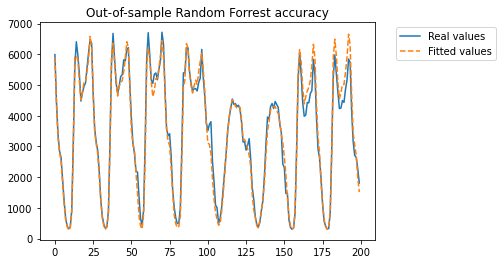

In [659]:
y1 = y_test[800:1000].array.to_numpy() # real values
y2 = y_best_forrest[800:1000] # predictions

import matplotlib.pyplot as plt
p1, =plt.plot(y1, label='Real values')
p2, =plt.plot(y2, linestyle='dashed', label='Fitted values')
plt.legend(handles=[p1, p2], title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Out-of-sample Random Forrest accuracy")

Then, let's plot predicted values.

In [656]:
#plt.plot(y_best_forrest[800:1000])

**I can observe that predictions are very accurate!** All the highs and lows on the chart are well captured. Also captured is the smaller movement on weekends.

### k-Nearest Neighbors Regressor

In [592]:
# KNN regressor wrapper
def CVTestKNNRegress(nFolds = 6, randomState=2137, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Lists to store the results
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Model validation on consecutive folds
    for train, test in kf.split(df.index.values):
        # Prepare the estimator
        clf = Pipeline([("scaler", RobustScaler()), ("classifier", KNeighborsRegressor(*args, **kwargs))])
        #clf = make_pipeline(RobustScaler(), KNeighborsRegressor(*args, **kwargs, n_jobs=-1))
        #clf = KNeighborsRegressor(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Train the model
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        predsTrain = clf.predict(df.iloc[train][features])
        preds = clf.predict(df.iloc[test][features])
        
        # Save each fold predictions
        predictions.append(preds.tolist().copy())
        
        # Store index for original dataset
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Get MAPE score from each fold
        trainScore = mean_absolute_percentage_error(df[target].iloc[train], predsTrain)
        testScore = mean_absolute_percentage_error(df[target].iloc[test], preds)

        # Store Mape results to list 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Optionally, print results for each fold
        if debug:
            print("Train MAPE:", trainScore,
                  "Valid MAPE:", testScore)
        
    return trainResults, testResults, predictions, indices

In [593]:
for k in range(2, 7, 1):
    trainResults, testResults, predictions, indices = CVTestKNNRegress(n_neighbors = k)
    print(k, np.mean(trainResults), np.mean(testResults))

2 0.11074829271258081 0.2330407546741119
3 0.15573328392651753 0.25338213604194965
4 0.19380159782974982 0.274472251118174
5 0.2244789853557383 0.2968356539969705
6 0.24810196565261644 0.3119441716754739


The smallest overfitting and best performance for the 4 nearest neighbours. But bad performance overall.

In [550]:
pipeline_best_knn = Pipeline([("scaler", RobustScaler()), ("classifier",KNeighborsRegressor(n_neighbors = 4))])

pipeline_best_knn.fit(x_train, y_train)
y_best_knn = pipeline_best_forrest.predict(x_test)

print(f'MAPE\ntraining: {round(mean_absolute_percentage_error(y_train, pipeline_best_knn.predict(x_train)) * 100, 4)}%\ntest: {round(mean_absolute_percentage_error(y_test, y_best_knn) * 100, 4)}%')

MAPE
training: 17.6694%
test: 177.9245%


On out-of-sample collection quite good results but still weaker than Random Forrest.

In [565]:
from sklearn.neighbors import KNeighborsRegressor
pipline_knn = Pipeline([("scaler", RobustScaler()),
                        ("classifier",KNeighborsRegressor())])


param_grid = {"classifier__n_neighbors": range(4, 7)}

grid_search = GridSearchCV(pipline_knn, param_grid, cv=5,
                           return_train_score=True)
grid_search.fit(x_train, y_train)

best_knn = grid_search.best_estimator_
best_knn.fit(x_train, y_train)
y_knn = best_knn.predict(x_train)

print(f'MAPE:\ntraining: {round(mean_absolute_percentage_error(y_train, y_knn) * 100, 4)}%, test: {round(mean_absolute_percentage_error(y_test, best_knn.predict(x_test)) * 100, 4)}%')

MAPE:
training: 23.0709%, test: 217.8419%


GridSearch indicated that the best model was that for the 7 nearest neighbours. However, its performance on the out-of-sample set is very poor.

## Support-Vector Machine

In [554]:
# SVM wrapper
def CVTestSVMRegress(nFolds = 6, randomState=2137, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Lists to store the results
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Model validation on consecutive folds
    for train, test in kf.split(df.index.values):
        # Prepare the estimator
        clf = Pipeline([("scaler", RobustScaler()), ("classifier", SVR(*args, **kwargs))])
        
        if debug:
            print(clf)
        # Train the model
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        predsTrain = clf.predict(df.iloc[train][features])
        preds = clf.predict(df.iloc[test][features])
        
        # Save each fold predictions
        predictions.append(preds.tolist().copy())
        
        # Store index for original dataset
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Get MAPE score from each fold
        trainScore = mean_absolute_percentage_error(df[target].iloc[train], predsTrain)
        testScore = mean_absolute_percentage_error(df[target].iloc[test], preds)

        # Store Mape results to list 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Optionally, print results for each fold
        if debug:
            print("Train MAPE:", trainScore,
                  "Valid MAPE:", testScore)
        
    return trainResults, testResults, predictions, indices

In [555]:
trainResults, testResults, predictions, indices = CVTestSVMRegress()
print(np.mean(trainResults), np.mean(testResults))

1.632848676341272 1.6338732706868762


Very bad performance and long time of fitting. I won't continue with tunning the parameters

# Test dataset predictions

At the very end it remains to make a prediction on the test set. Before that, I have to make the same modifications on the test set as I did on the training set.

In [556]:
traffic_test = pd.read_csv("data/traffic_test.csv")

traffic_test.drop(columns=['snow_mm', 'rain_mm'], inplace = True)
traffic_test = traffic_test[traffic_test.temperature > -50]

traffic_test['month'] = pd.to_datetime(traffic_test['date_time']).dt.month
traffic_test['hour'] = pd.to_datetime(traffic_test['date_time']).dt.hour
traffic_test["is_weekend"] = pd.to_datetime(traffic_test['date_time']).dt.dayofweek > 5
traffic_test['weekday'] = pd.to_datetime(traffic_test['date_time']).dt.dayofweek
traffic_test.drop(columns=['date_time'], inplace = True)

traffic_test['part_of_day'] = pd.cut(traffic_test['hour'], bins=[0,4,7,13,19,24], labels=['Night', 'Morning','Noon','Evening', 'Night'], include_lowest=True, ordered=False)
traffic_test['clouds_coverage_pct'] = pd.cut(x=traffic_test['clouds_coverage_pct'], bins=[-1,10,30,50,70,90,100], labels=[0, 20, 40, 60, 80, 100])

traffic_test = pd.get_dummies(traffic_test, columns=['weather_general', 'weather_detailed', 'month', 'hour', 'is_weekend', 'weekday', 'part_of_day'])

traffic_test["weather_general_Fog"] = traffic_test["weather_general_Fog"] + traffic_test["weather_general_Smoke"]
traffic_test.drop(columns=["weather_general_Smoke"], inplace=True)


traffic_test["weather_detailed_drizzle"] = traffic_test["weather_detailed_drizzle"] + traffic_test["weather_detailed_heavy intensity drizzle"]
traffic_test.drop(columns=["weather_detailed_heavy intensity drizzle"], inplace=True)

traffic_test["weather_detailed_drizzle"] = traffic_test["weather_detailed_drizzle"] + traffic_test["weather_detailed_shower drizzle"]
traffic_test.drop(columns=["weather_detailed_shower drizzle"], inplace=True)

traffic_test["weather_detailed_drizzle"] = traffic_test["weather_detailed_drizzle"] + traffic_test['weather_detailed_light intensity drizzle']
traffic_test.drop(columns=['weather_detailed_light intensity drizzle'], inplace=True)

traffic_test["weather_detailed_light rain"] = traffic_test["weather_detailed_light rain"] + traffic_test["weather_detailed_light rain and snow"]
traffic_test.drop(columns=["weather_detailed_light rain and snow"], inplace=True)

traffic_test["weather_detailed_light rain"] = traffic_test["weather_detailed_light rain"] + traffic_test['weather_detailed_proximity shower rain']
traffic_test.drop(columns=['weather_detailed_proximity shower rain'], inplace=True)

traffic_test["weather_detailed_thunderstorm with rain"] = traffic_test["weather_detailed_thunderstorm with rain"] + traffic_test["weather_detailed_thunderstorm with light drizzle"]
traffic_test.drop(columns=["weather_detailed_thunderstorm with light drizzle"], inplace=True)


traffic_test["weather_detailed_light snow"] = traffic_test["weather_detailed_light snow"] + traffic_test["weather_detailed_light shower snow"]
traffic_test.drop(columns=["weather_detailed_light shower snow"], inplace=True)

traffic_test["weather_detailed_snow"] = traffic_test["weather_detailed_snow"] + traffic_test["weather_detailed_sleet"]
traffic_test.drop(columns=["weather_detailed_sleet"], inplace=True)

traffic_test["weather_detailed_proximity thunderstorm"] = traffic_test["weather_detailed_proximity thunderstorm"] + traffic_test["weather_detailed_proximity thunderstorm with drizzle"]
traffic_test.drop(columns=["weather_detailed_proximity thunderstorm with drizzle"], inplace=True)

traffic_test["weather_detailed_proximity thunderstorm"] = traffic_test["weather_detailed_proximity thunderstorm"] + traffic_test["weather_detailed_proximity thunderstorm with rain"]
traffic_test.drop(columns=["weather_detailed_proximity thunderstorm with rain"], inplace=True)

traffic_test["weather_detailed_thunderstorm"] = traffic_test["weather_detailed_thunderstorm"] + traffic_test["weather_detailed_thunderstorm with heavy rain"] + traffic_test["weather_detailed_thunderstorm with light rain"] + traffic_test["weather_detailed_thunderstorm with rain"]
traffic_test.drop(columns=["weather_detailed_thunderstorm with heavy rain", "weather_detailed_thunderstorm with light rain", "weather_detailed_thunderstorm with rain"], inplace=True)

traffic_test["weather_detailed_fog"] = traffic_test["weather_detailed_fog"] + traffic_test["weather_detailed_smoke"]
traffic_test.drop(columns=["weather_detailed_smoke"], inplace=True)

traffic_test.drop(columns=['weather_detailed_fog', 'weather_detailed_snow', 'weather_detailed_thunderstorm', 'weather_detailed_mist', 'weather_detailed_drizzle', 'weather_detailed_haze', 'weather_detailed_proximity thunderstorm'], inplace=True)

scale_mapper = {'weather_detailed_sky is clear':0, 'weather_detailed_broken clouds':0.25, 'weather_detailed_few clouds':0.5 , 'weather_detailed_scattered clouds':0.75 , 'weather_detailed_overcast clouds':1}
traffic_test["clear_sky_ordinal"] = traffic_test[['weather_detailed_sky is clear', 'weather_detailed_broken clouds', 'weather_detailed_few clouds', 'weather_detailed_scattered clouds', 'weather_detailed_overcast clouds']].idxmax(axis=1).replace(scale_mapper)
traffic_test.drop(columns=['weather_detailed_sky is clear', 'weather_detailed_broken clouds', 'weather_detailed_few clouds', 'weather_detailed_scattered clouds', 'weather_detailed_overcast clouds'], inplace=True)

scale_mapper = {'weather_detailed_light intensity shower rain':0, 'weather_detailed_light rain':0.33 , 'weather_detailed_moderate rain':0.66 , 'weather_detailed_heavy intensity rain':1}
traffic_test["rain_strength_ordinal"] = traffic_test[['weather_detailed_light intensity shower rain', 'weather_detailed_light rain', 'weather_detailed_moderate rain', 'weather_detailed_heavy intensity rain']].idxmax(axis=1).replace(scale_mapper)
traffic_test.drop(columns=['weather_detailed_light intensity shower rain', 'weather_detailed_light rain', 'weather_detailed_moderate rain', 'weather_detailed_heavy intensity rain'], inplace=True)

scale_mapper = {'weather_detailed_light snow':0, 'weather_detailed_heavy snow':1}
traffic_test["snow_strength_ordinal"] = traffic_test[['weather_detailed_light snow', 'weather_detailed_heavy snow']].idxmax(axis=1).replace(scale_mapper)
traffic_test.drop(columns=['weather_detailed_light snow', 'weather_detailed_heavy snow'], inplace=True)

In [557]:
y_best_model = pipeline_best_forrest.predict(traffic_test)

I save the predictions to a CSV file.

In [342]:
#pd.DataFrame(y_best_model).to_csv("regression_SS.csv", header = None, index = None)

# Expected results

Expected value of **`MAPE`: 178%**